In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader,Subset
from sklearn.model_selection import KFold
import os
from torchinfo import summary

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# dataset_path = "/kaggle/input/dataset-gsoc12/dataset/train/sphere"
# npy_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.npy')])
# data_array_1 = np.array([np.load(os.path.join(dataset_path, f)) for f in npy_files])

# # Print shape of the final array
# print(f"Loaded {len(npy_files)} files into NumPy array of shape: {data_array_1.shape}")


In [25]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        in_features = resnet18.fc.in_features 
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [27]:
torch.cuda.empty_cache()

In [28]:
encoder = ResNet18(num_classes=3).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [29]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [30]:
# Mentioning training path
train_path = '/kaggle/input/gsoc123/new_dataset/train'

In [31]:
class_folders = torchvision.datasets.ImageFolder(train_path,transform=transformer)

In [32]:
from torch.optim.lr_scheduler import StepLR
# Define the scheduler


In [33]:
def CNN_train(epochs,class_folders, num_folds, lr):
    loss_fn = nn.CrossEntropyLoss()
    train_acc_values = []
    best_accuracy = 0.0
    test_acc_values = []
    num_epochs = epochs
    epoch_count = []
    iteration_details = [] 
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

    # Initialize KFold object
    kf = KFold(n_splits=num_folds, shuffle=True)
    
    # Loop through each fold
    for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
        print(f"Fold {fold + 1}/{num_folds}")
        
        dataset_train = Subset(class_folders, train_index)
        dataset_valid = Subset(class_folders, val_index)
    
        train_loader = torch.utils.data.DataLoader(
            dataset_train, batch_size=64, shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset_valid, batch_size=32, shuffle=True
        )
        
        # Training loop
        for epoch in range(num_epochs):
            # Set model to training mode
            encoder.train()
            
            train_accuracy = 0.0
            train_loss = 0.0
            
            for i, (images, labels) in enumerate(train_loader):
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                
                optimizer.zero_grad()
                outputs = encoder(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * images.size(0)
                _, prediction = torch.max(outputs.data, 1)
                train_accuracy += int(torch.sum(prediction == labels.data))
            
            train_accuracy = train_accuracy / len(train_index)
            train_loss = train_loss / len(train_index)
            
            # Validation loop
            encoder.eval()
            
            val_accuracy = 0.0
            val_loss = 0.0
            
            for i, (images, labels) in enumerate(val_loader):
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                
                outputs = encoder(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()* images.size(0)  # Accumulate the loss
                _, prediction = torch.max(outputs.data, 1)
                val_accuracy += int(torch.sum(prediction == labels.data))
                
            # Compute average loss and accuracy
            val_loss /= len(val_index)
            val_accuracy = val_accuracy / len(val_index)
            
            # Step the scheduler
            scheduler.step()
            
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
            
            # Save the best model
            if val_accuracy > best_accuracy:
                torch.save(encoder.state_dict(), 'best_model.pth')
                best_accuracy = val_accuracy
                
    print(f"Best Validation Accuracy: {best_accuracy}")

In [34]:
results =CNN_train(3,class_folders,10,0.001)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1/10
Epoch [1/3], Train Loss: 1.081, Train Accuracy: 0.387, Val Loss: 0.999, Validation Accuracy: 0.466
Epoch [2/3], Train Loss: 0.825, Train Accuracy: 0.603, Val Loss: 0.872, Validation Accuracy: 0.669
Epoch [3/3], Train Loss: 0.575, Train Accuracy: 0.761, Val Loss: 0.563, Validation Accuracy: 0.774
Fold 2/10
Epoch [1/3], Train Loss: 0.471, Train Accuracy: 0.811, Val Loss: 0.604, Validation Accuracy: 0.766
Epoch [2/3], Train Loss: 0.431, Train Accuracy: 0.831, Val Loss: 0.425, Validation Accuracy: 0.833
Epoch [3/3], Train Loss: 0.399, Train Accuracy: 0.846, Val Loss: 0.373, Validation Accuracy: 0.858
Fold 3/10
Epoch [1/3], Train Loss: 0.366, Train Accuracy: 0.860, Val Loss: 0.434, Validation Accuracy: 0.825
Epoch [2/3], Train Loss: 0.355, Train Accuracy: 0.864, Val Loss: 0.346, Validation Accuracy: 0.868
Epoch [3/3], Train Loss: 0.339, Train Accuracy: 0.868, Val Loss: 0.418, Validation Accuracy: 0.833
Fold 4/10
Epoch [1/3], Train Loss: 0.327, Train Accuracy: 0.876, Val Loss: 0.31

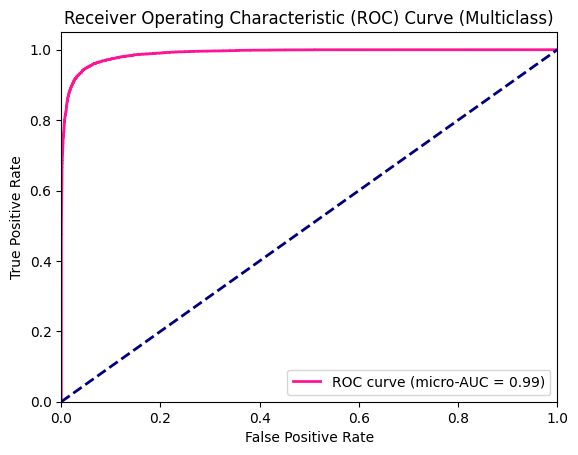

In [35]:
test_path='/kaggle/input/gsoc123/new_dataset/val'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_score_list = []
y_true_list = []

# Evaluate model
encoder.eval()
for images, labels in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    with torch.no_grad():
        y_score_batch = encoder(images)
    
    y_score_list.append(y_score_batch.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

y_score = np.vstack(y_score_list)
y_true = np.hstack(y_true_list)

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()